In [1]:
using Gen
using Random
using Distributions
using StatsBase: mean, std, quantile
using BenchmarkTools
using FilePathsBase;
using LinearAlgebra: dot, Diagonal
using JSON
import PyPlot
plt = PyPlot.plt

display(HTML("<style>.rendered_html.text_cell_render {max-width:700px; }</style>"));

HTML{String}("<style>.rendered_html.text_cell_render {max-width:700px; }</style>")

In [2]:
include("plotting.jl")
include("environment.jl")
include("raycaster.jl")

display(@doc load_env)

```
load_env(i::Union{Int64, Nothing}=nothing; 
         path=p"./data/HouseExpo_json")
```

Loads the i'th "House Expo" environment from the specified path to  the corresponding json files. If called with `nothing` it returns  the number of environments.

The data set can be found at `https://github.com/TeaganLi/HouseExpo` and is accompanied with an arXiv preprint:

> Li et al. "HouseExpo: A Large-scale 2D Indoor Layout Dataset for    Learning-based Algorithms on Mobile Robots", arXiv (2019).



# Load Environments

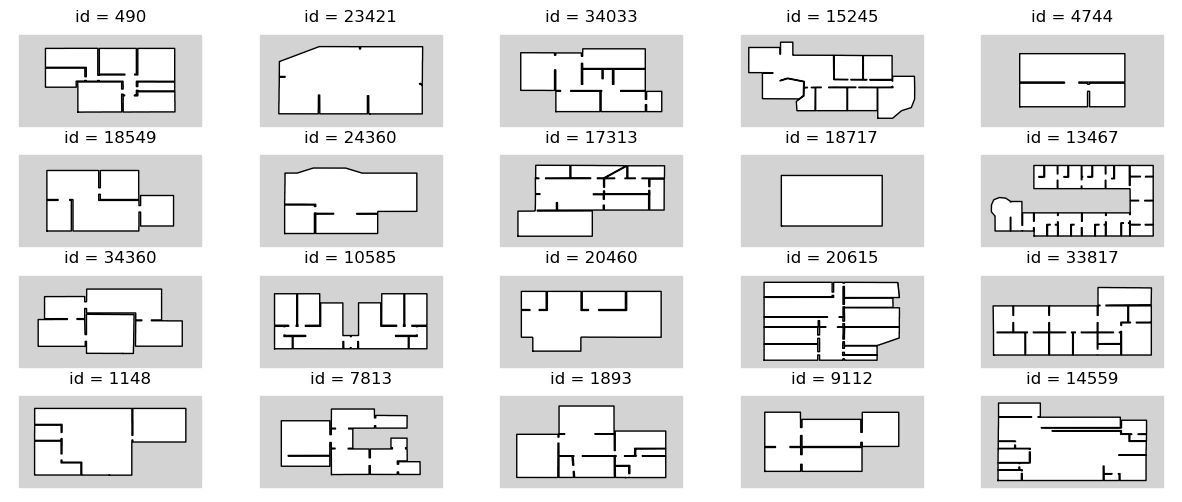

In [3]:
load_random_envs = true

if !load_random_envs
    E = [34596 17505  4322 32640 29165 
          2010 14178 12595 34812  7420 
         31296  9973  4709 14837  6530  
          6923 29392 25033 30415  5046]
else
    E = rand(1:load_env(nothing), 4, 5);
end



fig, axs = plt.subplots(size(E)..., figsize=(15,6));
for I in CartesianIndices(axs)
    i,j = Tuple(I)
    env = load_env(E[i,j]);
    axs[i,j].axis("off")
    draw_env!(env; ax=axs[i,j], title="id = $(E[i,j])")
end

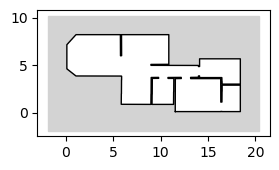

In [4]:
env = load_env(2010);
plt.figure(figsize=(3,3)); plt.gca().set_aspect(1.);
draw_env!(env);

# Utilities

In [5]:
"""
    StructIterator

A quick helper to enable destructuring assignments for my types.
"""
abstract type StructIterator end

function Base.iterate(x::T) where T <: StructIterator  
    n = fieldnames(T)
    getfield(x, n[1]), 2
end
    
function Base.iterate(x::T, state) where T <: StructIterator 
    n = fieldnames(T)
    if state <= length(n)
        return getfield(x, n[state]), state + 1
    else
        return nothing
    end
end

In [6]:
"""
    MultivariateUniform

Mulitivariate uniform distributions (surprise!).
"""
struct MultivariateUniform <: Gen.Distribution{Vector{Float64}} end
const mvuniform = MultivariateUniform()

function Gen.logpdf(::MultivariateUniform, x::AbstractArray{Float64,1}, b::AbstractArray{Float64,2})
    dist = Product(Uniform.(b[:,1], b[:,2]))
    Distributions.logpdf(dist, x)
end

function Gen.random(::MultivariateUniform, b::AbstractArray{Float64,2})
    dist = Product(Uniform.(b[:,1], b[:,2]))
    rand(dist)
end

(::MultivariateUniform)(b) = Gen.random(MultivariateUniform(), b)

has_output_grad(::MultivariateUniform) = false;
has_argument_grads(::MultivariateUniform) = (false,);

# Pose

In [7]:
"""
    Pose

Encoding the pose of a 2d agent as 
a 2d-position `x` and its head direction `hd`.
"""
struct Pose <: StructIterator
    x::Array{Float64}
    hd::Float64
end

"""
    pose_prior(env)

Samples a pose in the environment. Position
is sampled within the environment bounds and can
potentially land on the outside lawn.
"""
@gen function pose_prior(env::Env)
    x  ~ mvuniform(env.bounds)
    hd ~ uniform(0,2π)
    return Pose(x, hd)
end;

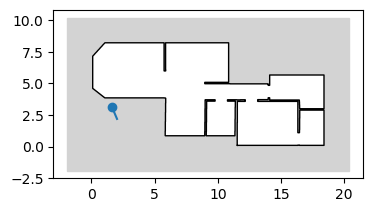

In [8]:
function draw_pose!(x,r; len=1., c="C0", ax=plt.gca(), zorder=4)
    v = [cos(r); sin(r)]
    y = x + len*v
    ax.scatter(x..., c=c, marker="o", zorder=zorder)
    ax.plot([x[1]; y[1]], [x[2]; y[2]], c=c, zorder=zorder)
end;

x, hd = pose_prior(env)
plt.figure(figsize=(4,4)); plt.gca().set_aspect(1.);
draw_env!(env)
draw_pose!(x, hd);

# Sensor model

In [10]:
"""
    sensor_model(pose, 
                 env, 
                 n, 
                 fov, 
                 angular_noise, 
                 depth_noise)

Samples a vector of a pseudo lidar measurement
given a pose in an environment.
"""
@gen function sensor_model(pose::Pose, env::Env, n, fov, angular_noise, depth_noise, max_depth)
    x, rot = pose
    Iₙ = Diagonal(ones(n))
    
    σₐ = (angular_noise/180)*π
    Σₐ = σₐ .* Iₙ 
    
    a′ = angles(fov, n) .+ rot
    a  = @trace(mvnormal(a′, Σₐ), :ray_directions)

    
    z′ = cast(lightcone(a), x, env; max_val=max_depth)
    σᵣ = depth_noise.*z′ .+ 0.000001
    Σᵣ = σᵣ .* Iₙ
    z  = @trace(mvnormal(z′, Σᵣ), :z)
    
    #     
    # Rem: There should be a "correct" noise model.
    # ---  I will look that up at some point.
    
    return z, a′
end;


# Rem: I am not sure if I want to keep this.
# --- 
mutable struct SensorArgs <: StructIterator
    num_rays::Int
    fov::Int
    angular_noise::Float64
    depth_noise::Float64
    max_depth::Float64
end

In [11]:
function draw_sense!(x, rot, z, sensor_args; ax=plt.gca())
    θs = angles(sensor_args.fov, sensor_args.num_rays) .+ rot
    hits = z.*hcat(cos.(θs), sin.(θs)) .+ x'
    valid = z .< sensor_args.max_depth - 5
    ax.scatter(hits[valid,1], hits[valid,2], c="C1", marker=".", alpha=0.5)
end

draw_sense! (generic function with 1 method)

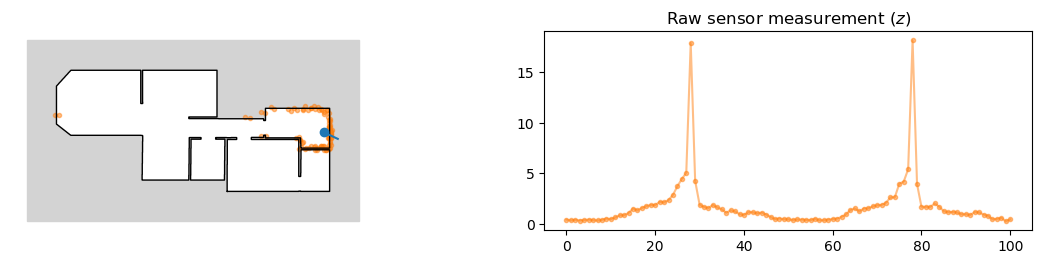

In [12]:
pose = pose_prior(env)
sensor_args = SensorArgs(101, 360, 1e-2, 1e-2, 40.)
z, = sensor_model(pose, env, sensor_args...)

############
############
fig, axs = plt.subplots(1,2,figsize=(12,3), gridspec_kw=Dict("width_ratios" => [5,4])); 
axs[1].set_aspect(1.);
axs[1].axis("off")
draw_env!(env; ax=axs[1]);
draw_pose!(pose...; ax=axs[1]);
draw_sense!(pose..., z, sensor_args; ax=axs[1]);
axs[2].set_title("Raw sensor measurement (\$z\$)")
axs[2].plot(z, marker=".", c="C1", alpha=0.5);
plt.tight_layout(2.);

# Naive localization

In [13]:
"""
    sensor_model_with_pose_prior(env, sensor_args)

Combines the sensor model with the pose prior.
"""
@gen function sensor_model_with_pose_prior(env::Env, sensor_args)
    pose  ~ pose_prior(env)
    sense ~ sensor_model(pose, env, sensor_args...)
    
    return pose, sense
end;

In [16]:
function draw_tr!(tr; ax=plt.gca())
    env, sensor_args = get_args(tr)
    pose = tr[:pose]
    z    = tr[:sense => :z]

    draw_env!(env; ax=ax);
    draw_pose!(pose...; ax=ax);
    draw_sense!(pose..., z, sensor_args; ax=ax);
end

draw_tr! (generic function with 1 method)

**Creating a ground truth**

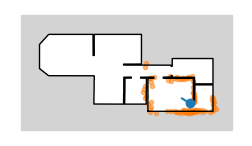

In [22]:
sensor_args = SensorArgs(100, 360, 1e-2, 1e-2, 40.)
tr0 = Gen.simulate(sensor_model_with_pose_prior, (env, sensor_args));
obs = choicemap((:sense => :z) => tr0[:sense => :z])

plt.figure(figsize=(3,3)); plt.gca().set_aspect(1.);
plt.gca().axis("off")
draw_tr!(tr0);

**Naive inference**

In [23]:
trs,ws, = Gen.importance_sampling(sensor_model_with_pose_prior, (env, sensor_args), obs, 2000);
xs  = hcat([tr[:pose => :x] for tr in trs]...)'
hds = [tr[:pose => :hd] for tr in trs]
vs = hcat(cos.(hds), sin.(hds));


In [24]:
inside = [is_inside(x, env.segs) for x in eachrow(xs)]
xs = xs[inside,:]
hds = hds[inside]
vs = vs[inside,:]
ws = ws[inside];

cmap = PyPlot.cm.get_cmap("cool");

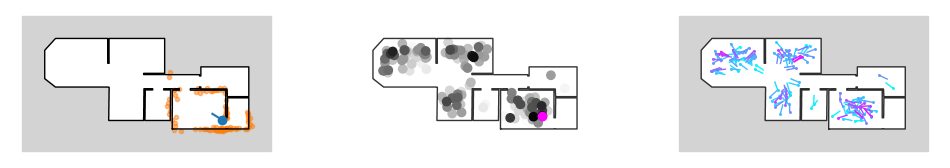

In [25]:
perm = sortperm(ws)
q = quantile(ws, 0.9)
above = q .<= ws


cs = clamp.(ws, q, 0)
cs .-= min(cs...)
cs ./= max(cs...)

fig, axs = plt.subplots(1,3,figsize=(12,4)); 

axs[2].set_aspect(1.); axs[2].axis("off");
draw_env!(env; ax=axs[2], 
    alpha=0.8, zorder=10, wall="black", floor="w", grass="w");
axs[2].scatter(xs[perm,1], xs[perm,2], c=cs[perm], marker="o", alpha=1., cmap="binary", zorder=2)  
axs[2].scatter(xs[perm[end],:]..., c="magenta", marker="o",  alpha=1., linewidth=1, zorder=3)    

    

axs[3].set_aspect(1.); axs[3].axis("off");
draw_env!(env; ax=axs[3], 
        alpha=0.8, zorder=10, wall="black", floor="w", grass="lightgray");
for i in perm
    if !above[i]
        continue
    end
    axs[3].plot([xs[i,1];(xs + 0.8.*vs)[i,1]],[xs[i,2];(xs + 0.8.*vs)[i,2]], c=cmap(cs[i]), zorder=5, linewidth=1) ;
    axs[3].scatter(xs[i,:]..., c=[cmap(cs[i])], marker=".", s=5, zorder=4);
end

axs[1].set_aspect(1.)
axs[1].axis("off")
draw_tr!(tr0; ax=axs[1]);


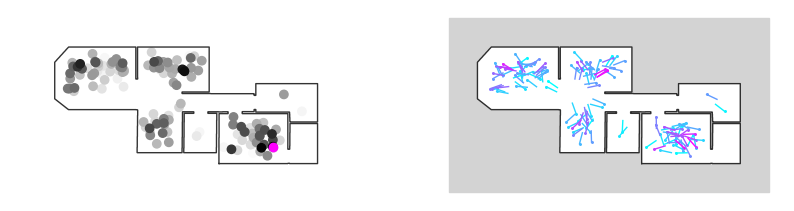

In [26]:
perm = sortperm(ws)
q = quantile(ws, 0.9)
above = q .<= ws


cs = clamp.(ws, q, 0)
cs .-= min(cs...)
cs ./= max(cs...)

fig, axs = plt.subplots(1,2,figsize=(10,6)); 

axs[1].set_aspect(1.); axs[1].axis("off");
draw_env!(env; ax=axs[1], 
    alpha=0.8, zorder=10, wall="black", floor="w", grass="w");
axs[1].scatter(xs[perm,1], xs[perm,2], c=cs[perm], marker="o", alpha=1., cmap="binary", zorder=2)  
axs[1].scatter(xs[perm[end],:]..., c="magenta", marker="o",  alpha=1., linewidth=1, zorder=3)    

    

axs[2].set_aspect(1.); axs[2].axis("off");
draw_env!(env; ax=axs[2], 
        alpha=0.8, zorder=10, wall="black", floor="w", grass="lightgray");
for i in perm
    if !above[i]
        continue
    end
    axs[2].plot([xs[i,1];(xs + 0.8.*vs)[i,1]],[xs[i,2];(xs + 0.8.*vs)[i,2]], c=cmap(cs[i]), zorder=5, linewidth=1) ;
    axs[2].scatter(xs[i,:]..., c=[cmap(cs[i])], marker=".", s=5, zorder=4);
end
